# DA3 Assignment 2
## Finding fast growing firms - Predicting Probabilities and Classification
Presented by: Yllke Berisha & Bo Wang

This notebook is organized into the following sections:
- **TASK 1, PART I:** Probability Prediction (model building, CV, performance comparison)
- **TASK 1, PART II:** Classification with Loss Function (optimal thresholds, expected loss)
- **TASK 1, PART III:** Discussion of Results (confusion matrix, interpretation)
- **TASK 2:** Industry-Specific Analysis (Manufacturing vs Services)

In [1]:
import os
import sys
import warnings
import pyfixest as pf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

In [2]:
# Current script folder
path = os.getcwd()
base_dir = path.split("da_case_studies")[0]

# Set the location of your data directory
data_dir = base_dir + "da_data_repo"

# location folders
data_in = os.path.join(data_dir, "bisnode-firms/clean/")
data_out = os.path.join(data_dir, "bisnode-firms/")
output = os.path.join(data_out, "output/")
func = os.path.join(base_dir, "da_case_studies/ch00-tech-prep/")
sys.path.append(func)

# Import the prewritten helper functions
import py_helper_functions as da

sns.set_theme(rc=da.da_theme, palette=da.color)

## Import data

In [3]:
# !!! make sure you have run ch17-firm-exit-data-prep.ipynb before
data = pd.read_csv(data_out + "bisnode_firms_clean.csv")

In [4]:
data.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,...,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
count,17650.0,1.765000e+04,1.765000e+04,1.765000e+04,1.765000e+04,17650.000000,1.765000e+04,1.765000e+04,1.765000e+04,1.765000e+04,...,17650.000000,17650.000000,17650.000000,17650.000000,17650.000000,1.765000e+04,17650.000000,17650.000000,17650.000000,17650.000000
mean,2012.0,1.530811e+11,9.782193e+03,1.039516e+05,8.806618e+04,435.254199,1.672572e+03,1.233549e+03,1.536281e+05,7.160997e+03,...,0.004306,0.136147,0.263739,0.647323,0.134618,1.192269e+01,0.023003,0.036261,0.004003,0.279541
std,0.0,1.376204e+11,5.126902e+04,4.508443e+05,4.320066e+05,7311.798503,3.378159e+04,3.306023e+04,1.144839e+06,1.338463e+05,...,0.065480,0.342955,0.440672,1.511459,0.341324,1.031838e+01,0.149917,0.186943,0.528716,0.593133
min,2012.0,1.001541e+06,-1.489630e+04,0.000000e+00,-8.759259e+03,-1418.518555,-1.740741e+02,-2.484481e+05,0.000000e+00,-1.091879e+07,...,0.000000,0.000000,0.000000,0.083333,0.000000,2.074996e-07,0.000000,0.000000,-1.500000,0.000000
25%,2012.0,2.881660e+10,1.518519e+02,3.604630e+03,3.811111e+03,0.000000,0.000000e+00,0.000000e+00,2.518519e+02,-5.966667e+03,...,0.000000,0.000000,0.000000,0.130952,0.000000,3.851465e+00,0.000000,0.000000,-0.165294,0.000876
50%,2012.0,1.144412e+11,9.962963e+02,1.219444e+04,1.491667e+04,0.000000,0.000000e+00,0.000000e+00,5.418519e+03,3.370370e+02,...,0.000000,0.000000,0.000000,0.298611,0.000000,9.396190e+00,0.000000,0.000000,0.000000,0.025805
75%,2012.0,2.557897e+11,4.439815e+03,4.234630e+04,4.898055e+04,0.000000,0.000000e+00,0.000000e+00,4.455833e+04,4.473148e+03,...,0.000000,0.000000,1.000000,0.641504,0.000000,1.704147e+01,0.000000,0.000000,0.155571,0.179278
max,2012.0,4.641050e+11,3.570863e+06,1.874527e+07,3.660118e+07,666300.000000,3.266667e+06,3.253704e+06,1.036673e+08,4.378226e+06,...,1.000000,1.000000,1.000000,42.118057,1.000000,4.771708e+01,1.000000,1.000000,1.500000,2.250000


## Define helper functions

In [5]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    # Plot loss curve
    sns.lineplot(x=all_coords_copy["thresholds"], y=all_coords_copy["loss"])

    # Vertical line for optimal threshold
    plt.axvline(x=t, linestyle="--")

    # Annotations
    plt.text(
        t - 0.03,
        all_coords_copy["loss"].max() - 0.7,
        f"Best threshold: {round(t, 2)}",
        color=da.color[1],
        rotation=90,
        fontsize=8,
    )
    plt.text(t + 0.06, l, f"{round(l, 2)}", fontsize=8)

    # Labels and limits
    plt.xlabel("Thresholds")
    plt.ylabel("Expected loss")
    plt.xlim(-0.01, 1.01)
    plt.xticks(np.arange(0, 1.1, 0.1))

    # Style
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Plot ROC curve
    sns.lineplot(x=fpr, y=tpr, linewidth=1)

    # Fill area under curve
    plt.fill_between(fpr, tpr, alpha=0.3, color="mediumaquamarine")

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], linestyle="dotted", color="black", linewidth=0.9)

    # Labels and limits
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Style
    sns.despine()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    # Plot ROC curve
    sns.lineplot(x=all_coords_copy["sp"], y=all_coords_copy["se"])

    # Highlight optimal threshold point
    plt.scatter(sp, se, color="black", s=10)
    plt.text(sp, se + 0.03, f"{round(sp, 2)}, {round(se, 2)}", fontsize=10, ha="center")

    # Fill area under curve
    plt.fill_between(
        all_coords_copy["sp"],
        all_coords_copy["se"],
        alpha=0.3,
        color="mediumaquamarine",
    )

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], linestyle="dotted", color="black", linewidth=0.9)

    # Labels and limits
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.xlim(0, 1.01)
    plt.ylim(0, 1.01)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Style
    sns.despine()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()

---
# TASK 1, PART I: Probability Prediction

In this section, we:
1. Define variable sets for modeling
2. Build multiple logit models with different specifications
3. Build LASSO model for regularized regression
4. Build Random Forest model for comparison
5. Use 5-fold cross-validation to evaluate model performance
6. Compare models using RMSE and AUC metrics
7. Select the best model for holdout evaluation

## Model building

### Define variable sets 

 Main firm variables

In [6]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

Further financial variables

In [7]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

 Flag variables

In [8]:
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

Growth variables

In [9]:
d1 = [
    "d1_sales_mil_log_mod",
    "d1_sales_mil_log_mod_sq",
    "flag_low_d1_sales_mil_log",
    "flag_high_d1_sales_mil_log",
]

Human capital related variables

In [10]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

 Firms history related variables

In [11]:
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

interactions for logit, LASSO

In [12]:
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*d1_sales_mil_log_mod",
    "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "sales_mil_log*age",
    "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

## Model setups

1. Simple logit models

In [13]:
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "C(ind2_cat)",
]
M3 = ["sales_mil_log", "sales_mil_log_sq"] + firm + engvar + d1
M4 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
)
M5 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
    + interactions1
    + interactions2
)

2. logit+LASSO

In [14]:
logit_lasso_vars = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + firm
    + qualityvars
    + interactions1
    + interactions2
)

3. CART and RF (no interactions, no modified features)

In [15]:
rfvars = ["sales_mil", "d1_sales_mil_log"] + rawvars + hr + firm + qualityvars

## Quick reminder about probability models

 Linear probability model

In [16]:
ols_modelx2 = smf.ols("fast_growth~" + "+".join(M2), data).fit(cov_type="HC1")
ols_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fast_growth   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     54.89
Date:                Sun, 15 Feb 2026   Prob (F-statistic):          1.03e-192
Time:                        01:32:58   Log-Likelihood:                -10714.
No. Observations:               17650   AIC:                         2.147e+04
Df Residuals:                   17631   BIC:                         2.161e+04
Df Model:                          18                                         
Covariance Type:                  HC1                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.3166      0.020     15.781      0.000       0.277       0.356
C(ind2_cat)[T.27.0]        -0.0130      0.024     -0.548      0.583      -0.060       0.034
C(ind2_cat)[T.28.0]         0.0089      0.018      0.484      0.628      -0.027       0.045
C(ind2_cat)[T.29.0]         0.0553      0.034      1.641      0.101      -0.011       0.121
C(ind2_cat)[T.30.0]         0.0461      0.043      1.065      0.287      -0.039       0.131
C(ind2_cat)[T.33.0]        -0.0056      0.019     -0.301      0.763      -0.042       0.031
C(ind2_cat)[T.55.0]        -0.0610      0.018     -3.325      0.001      -0.097      -0.025
C(ind2_cat)[T.56.0]        -0.0751      0.016     -4.703      0.000      -0.106      -0.044
sales_mil_log              -0.0125      0.005     -2.498      0.013      -0.022      -0.003
sales_mil_log_sq            0.0042      0.001      4.951      0.000       0.003       0.006
d1_sales_mil_log_mod        0.0478      0.007      6.839      0.000       0.034       0.062
profit_loss_year_pl        -0.0886      0.012     -7.474      0.000      -0.112      -0.065
fixed_assets_bs            -0.0001      0.011     -0.011      0.991      -0.021       0.021
share_eq_bs                 0.0351      0.009      4.113      0.000       0.018       0.052
curr_liab_bs                0.0503      0.015      3.311      0.001       0.021       0.080
curr_liab_bs_flag_high     -0.0410      0.013     -3.077      0.002      -0.067      -0.015
curr_liab_bs_flag_error    -0.0744      0.132     -0.563      0.574      -0.333       0.185
age                        -0.0099      0.001    -18.543      0.000      -0.011      -0.009
foreign_management          0.0183      0.011      1.603      0.109      -0.004       0.041
==============================================================================
Omnibus:                     6871.214   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2865.430
Skew:                           0.836   Prob(JB):                         0.00
Kurtosis:                       1.952   Cond. No.                         787.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [17]:
logit_modelx2 = smf.logit("fast_growth~" + "+".join(M2), data).fit()
logit_modelx2.summary()

Optimization terminated successfully.
         Current function value: 0.580218
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            fast_growth   No. Observations:                17650
Model:                          Logit   Df Residuals:                    17631
Method:                           MLE   Df Model:                           18
Date:                Sun, 15 Feb 2026   Pseudo R-squ.:                 0.04416
Time:                        01:32:58   Log-Likelihood:                -10241.
converged:                       True   LL-Null:                       -10714.
Covariance Type:            nonrobust   LLR p-value:                2.104e-189
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.7952      0.103     -7.746      0.000      -0.996      -0.594
C(ind2_cat)[T.27.0]        -0.0709      0.120     -0.590      0.555      -0.306       0.164
C(ind2_cat)[T.28.0]         0.0455      0.090      0.504      0.614      -0.132       0.223
C(ind2_cat)[T.29.0]         0.2635      0.157      1.683      0.092      -0.043       0.570
C(ind2_cat)[T.30.0]         0.2077      0.193      1.075      0.282      -0.171       0.586
C(ind2_cat)[T.33.0]        -0.0422      0.090     -0.469      0.639      -0.219       0.134
C(ind2_cat)[T.55.0]        -0.3177      0.092     -3.463      0.001      -0.497      -0.138
C(ind2_cat)[T.56.0]        -0.3908      0.079     -4.932      0.000      -0.546      -0.236
sales_mil_log              -0.0870      0.029     -3.044      0.002      -0.143      -0.031
sales_mil_log_sq            0.0156      0.004      3.508      0.000       0.007       0.024
d1_sales_mil_log_mod        0.2224      0.032      6.875      0.000       0.159       0.286
profit_loss_year_pl        -0.4140      0.056     -7.336      0.000      -0.525      -0.303
fixed_assets_bs            -0.0043      0.055     -0.078      0.938      -0.112       0.104
share_eq_bs                 0.1717      0.043      3.956      0.000       0.087       0.257
curr_liab_bs                0.2490      0.076      3.294      0.001       0.101       0.397
curr_liab_bs_flag_high     -0.1978      0.066     -2.995      0.003      -0.327      -0.068
curr_liab_bs_flag_error    -0.3718      0.814     -0.457      0.648      -1.968       1.224
age                        -0.0515      0.003    -18.176      0.000      -0.057      -0.046
foreign_management          0.0963      0.057      1.684      0.092      -0.016       0.208
===========================================================================================
"""

With Logit we need to calculate average marginal effects (dy/dx) to be able to interpret the coefficients (under some assumptions...)

In [18]:
logit_modelx2.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            fast_growth
Method:                          dydx
At:                           overall
===========================================================================================
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
C(ind2_cat)[T.27.0]        -0.0140      0.024     -0.590      0.555      -0.060       0.032
C(ind2_cat)[T.28.0]         0.0090      0.018      0.504      0.614      -0.026       0.044
C(ind2_cat)[T.29.0]         0.0519      0.031      1.684      0.092      -0.009       0.112
C(ind2_cat)[T.30.0]         0.0409      0.038      1.075      0.282      -0.034       0.116
C(ind2_cat)[T.33.0]        -0.0083      0.018     -0.469      0.639      -0.043       0.026
C(ind2_cat)[T.55.0]        -0.0626      0.018     -3.467      0.001      -0.098      -0.027
C(ind2_cat)[T.56.0]        -0.0770      0.016     -4.943      0.000      -0.108      -0.046
sales_mil_log              -0.0171      0.006     -3.046      0.002      -0.028      -0.006
sales_mil_log_sq            0.0031      0.001      3.513      0.000       0.001       0.005
d1_sales_mil_log_mod        0.0438      0.006      6.908      0.000       0.031       0.056
profit_loss_year_pl        -0.0816      0.011     -7.375      0.000      -0.103      -0.060
fixed_assets_bs            -0.0008      0.011     -0.078      0.938      -0.022       0.020
share_eq_bs                 0.0338      0.009      3.961      0.000       0.017       0.051
curr_liab_bs                0.0491      0.015      3.298      0.001       0.020       0.078
curr_liab_bs_flag_high     -0.0390      0.013     -2.997      0.003      -0.064      -0.013
curr_liab_bs_flag_error    -0.0733      0.160     -0.457      0.648      -0.388       0.241
age                        -0.0101      0.001    -18.730      0.000      -0.011      -0.009
foreign_management          0.0190      0.011      1.685      0.092      -0.003       0.041
===========================================================================================
"""

## 0. Separate train and holdout data

In [19]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [20]:
print("Total")
print(data["fast_growth"].value_counts(normalize=True))
print("Train")
print(data_train["fast_growth"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["fast_growth"].value_counts(normalize=True))


Total
fast_growth
0.0    0.704476
1.0    0.295524
Name: proportion, dtype: float64
Train
fast_growth
0.0    0.702833
1.0    0.297167
Name: proportion, dtype: float64
Holdout
fast_growth
0.0    0.711048
1.0    0.288952
Name: proportion, dtype: float64


## Cross-Validation for Logit Models

We use 5-fold cross-validation to evaluate our logit models (M1-M5).
Performance is measured using RMSE (Brier score) and AUC.

## 1. Predict probabilities with logit and Lasso with CV

Specify 5 fold cross-validation method

In [21]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

### a) cross validate logit models

Set up X-vars

In [22]:
logit_model_vars = [M1, M2, M3, M4, M5]

Set up Logit model object

No regularisation needed so setting the paremeter to very high value

In [23]:
C_value_logit = [1e20]

In [24]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

In [25]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5
0,0.457071,0.451474,0.446976,0.443774,0.443991
1,0.444317,0.440299,0.435901,0.432761,0.431186
2,0.449332,0.441784,0.434388,0.432584,0.432418
3,0.449140,0.443769,0.442930,0.440497,0.441838
4,0.452004,0.445551,0.439465,0.435990,0.434904


## Logit + LASSO Regularization

LASSO adds L1 regularization to logit regression, performing automatic variable selection.
We tune the regularization parameter using cross-validation.

### b) Logit + LASSO

In [26]:
model_equation = "fast_growth~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

Normalise X vars for Lasso

In [27]:
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

Set regularization parameters

In [28]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

Initialize and fit Logit Lasso

In [29]:
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

See CV-fold RMSE-s (negative brier score)

In [30]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000885,0.467905
1,0.046416,0.001907,0.450458
2,0.021544,0.004109,0.441957
3,0.010000,0.008853,0.438461
4,0.004642,0.019073,0.437000
5,0.002154,0.041091,0.436475
6,0.001000,0.088527,0.436469
7,0.000464,0.190725,0.436681
8,0.000215,0.410906,0.437005
9,0.000100,0.885269,0.437278


Save best lambda's index for later use

In [31]:
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

Extract CV test RMSE for the Lasso with best lambda

In [32]:
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

## Model Performance Comparison

Compare all models (Logit M1-M5 and LASSO) using:
- AUC (Area Under ROC Curve)
- RMSE (Root Mean Squared Error / Brier Score)

Higher AUC and lower RMSE indicate better performance.

## 2.  AUC, Calibration Curve, Confusion Matrix, ROC

0. Calculate AUC for folds


First, for logits

In [33]:
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

For Lasso

In [34]:
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

Put a summary frame together

In [35]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [36]:
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

110

In [37]:
len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

110

In [38]:
summary.round(3)

,Number of Coefficients,CV RMSE,CV AUC
M1,12,0.450,0.606
M2,19,0.445,0.640
M3,36,0.440,0.660
M4,79,0.437,0.665
M5,153,0.437,0.667
LASSO,110,0.436,0.670


### Take best model and estimate RMSE on holdout  

M4, M5 and LASSO are practically the same - go with the simplest model, M4

In [39]:
best_logit = logit_models["M4"]
model_equation = "fast_growth~" + "+".join(M4)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)

Best logit holdout RMSE


In [40]:
data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["fast_growth"]), 3)

np.float64(0.434)

### a) Calibration curve

how well do estimated vs actual event probabilities relate to each other?


---
# TASK 1, PART II: Classification with Loss Function

In this section, we:
1. Define a loss function that accounts for the asymmetric costs of classification errors
2. Find optimal probability thresholds for each model
3. Calculate expected loss for different thresholds
4. Select the threshold that minimizes expected loss
5. Evaluate the final model on the holdout set

### a) Calibration curve

how well do estimated vs actual event probabilities relate to each other?


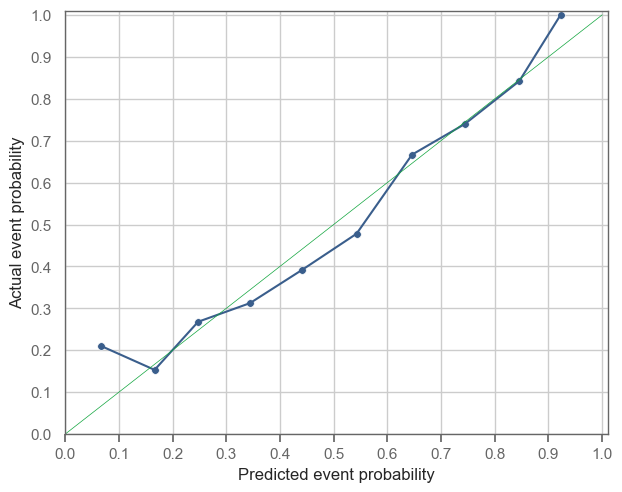

In [41]:
da.create_calibration_plot(
    data_holdout,
    prob_var="best_logit_pred_proba",
    actual_var="fast_growth",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)


## Confusion Matrix with Different Thresholds

Before applying the loss function, let's explore how different probability thresholds affect classification:
- Threshold = 0.5 (standard)
- Threshold = mean of predicted probabilities (data-driven)

### b) Confusion table with different tresholds

fast_growth: the threshold 0.5 is used to convert probabilities to binary classes

In [42]:
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (no fast_growth): ", counts[0])
print(values[1], " (fast_growth): ", counts[1])

0.0  (no fast_growth):  3227
1.0  (fast_growth):  303


Confusion matrix: summarize different type of errors and successfully predicted cases

positive = "yes": explicitly specify the positive case

In [43]:
cm_object1 = confusion_matrix(
    data_holdout["fast_growth"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actul no defaul", "Actual fast_growth"],
    columns=["Predicted no fast_growth", "Predicted fast_growth"],
)
cm1

,Predicted no fast_growth,Predicted fast_growth
Actul no defaul,2397,113
Actual fast_growth,830,190


In [44]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.5, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actul no defaul", "Actual fast_growth"],
    columns=["Predicted no fast_growth", "Predicted fast_growth"],
)
cm1b

,Predicted no fast_growth,Predicted fast_growth
Actul no defaul,2397,113
Actual fast_growth,830,190


A sensible choice: mean of predicted probabilities

In [45]:
mean_predicted_fast_growth_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_fast_growth_prob, 3)

np.float64(0.297)

In [46]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_fast_growth_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actul no defaul", "Actual fast_growth"],
    columns=["Predicted no fast_growth", "Predicted fast_growth"],
)
cm2

,Predicted no fast_growth,Predicted fast_growth
Actul no defaul,1694,816
Actual fast_growth,480,540


### c) Visualize ROC (with thresholds in steps) on holdout

What if we want to compare multiple thresholds?

First, discrete ROC (with thresholds in steps) on holdout

### c) Visualize ROC (with thresholds in steps) on holdout

What if we want to compare multiple thresholds?

First, discrete ROC (with thresholds in steps) on holdout

In [47]:
thresholds = np.arange(0.05, 0.76, 0.05)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["fast_growth"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [48]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

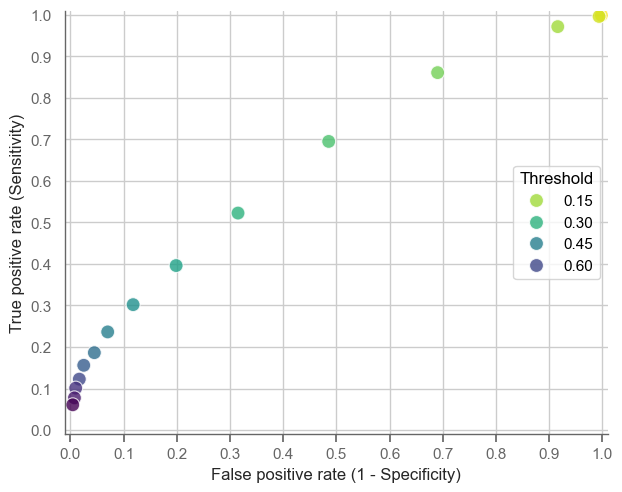

In [49]:
scatter = sns.scatterplot(
    data=tpr_fpr_for_thresholds,
    x="false_positive_rates",
    y="true_positive_rates",
    hue="thresholds",
    palette="viridis_r",
    s=100,
    alpha=0.8,
)

plt.xlabel("False positive rate (1 - Specificity)")
plt.ylabel("True positive rate (Sensitivity)")
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.legend(title="Threshold", loc="center right")
sns.despine()
plt.show()

Continuous ROC on holdout with best model

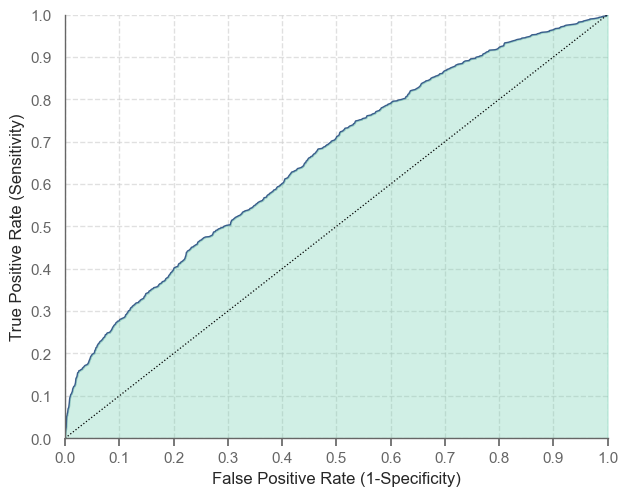

In [50]:
create_roc_plot(data_holdout["fast_growth"], data_holdout["best_logit_pred_proba"])

## Loss Function and Optimal Threshold

We define a loss function that reflects the relative costs of false positives and false negatives.
The optimal threshold is chosen to minimize expected loss.

## 3. We have a loss function

Introduce loss function

Relative cost of of a false negative classification (as compared with a false positive classification)


In [51]:
# --------------------------------------------------
# Define Loss Function Parameters
# --------------------------------------------------

# FP (False Positive): You predicted fast growth (invested), but it did not grow.
# Cost = Administrative costs of due diligence or small principle loss.
FP = 2  

# FN (False Negative): You predicted no growth (did not invest), but it was a "unicorn".
# Cost = Opportunity cost of missing out on high returns.
# In a Venture Capital context, this is usually much higher than FP.
FN = 10 

# Calculate relative cost (this variable is used later for finding optimal threshold)
cost = FN / FP

print(f"Loss Function defined: FP={FP}, FN={FN}, Cost Ratio={cost}")

Loss Function defined: FP=2, FN=10, Cost Ratio=5.0


The prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))


In [52]:
prevelance = y_train.sum() / len(y_train)

Draw ROC Curve and find optimal threshold with loss function 

The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

Iterate through:
 1. models
 2. Folds

In [53]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("fast_growth ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["fast_growth"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

In [54]:
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()


In [55]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.186479,0.178649,1.383428,1.400142
1,M2,0.151181,0.142202,1.383853,1.375354
2,M3,0.160749,0.156869,1.364023,1.369688
3,M4,0.154932,0.146654,1.367280,1.386686
4,M5,0.141282,0.150721,1.354958,1.371813
5,LASSO,0.155241,0.159576,1.351983,1.346317


Create loss plot based on Fold5 in CV 

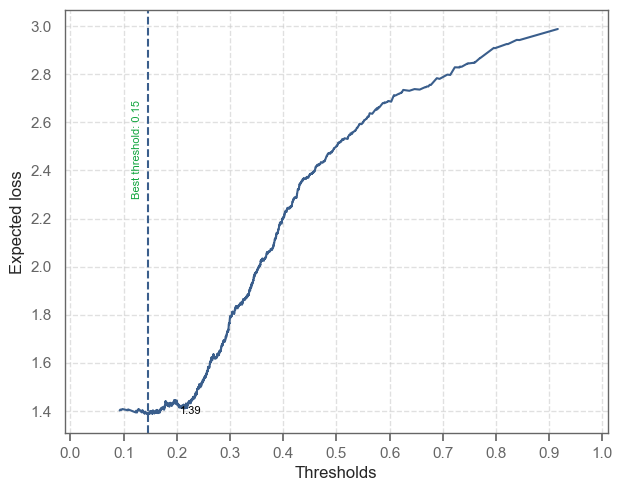

In [56]:
model_to_plot = "M4"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

Create roc plot plot based on Fold5 in CV

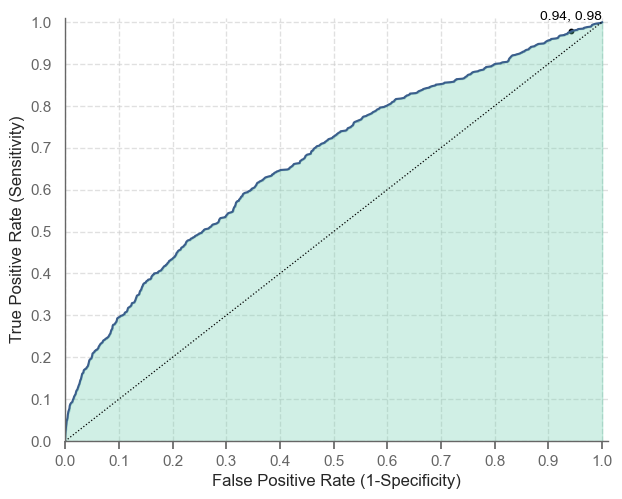

In [57]:
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)

Let's see our chosen model, M4's holdout expected loss

In [58]:
best_logit_optimal_treshold = best_thresholds_cv["M4"]

# Get expected loss on holdout
holdout_treshold = np.where(
    data_holdout["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(
    data_holdout["fast_growth"], holdout_treshold, labels=[0, 1]
).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(data_holdout["fast_growth"])
round(expected_loss_holdout, 3)

np.float64(1.384)

CM on holdout

---
# TASK 1, PART III: Discussion of Results & Random Forest

In this section, we:
1. Build and evaluate a Random Forest model as an alternative to logit
2. Compare Random Forest performance with logit models
3. Discuss the interpretation of results
4. Summarize final model performance on holdout data

# PREDICTION WITH RANDOM FOREST

In [59]:
y_train, rfvars_train = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data_holdout)

## Graph example for decision tree

<Figure size 700x550 with 0 Axes>

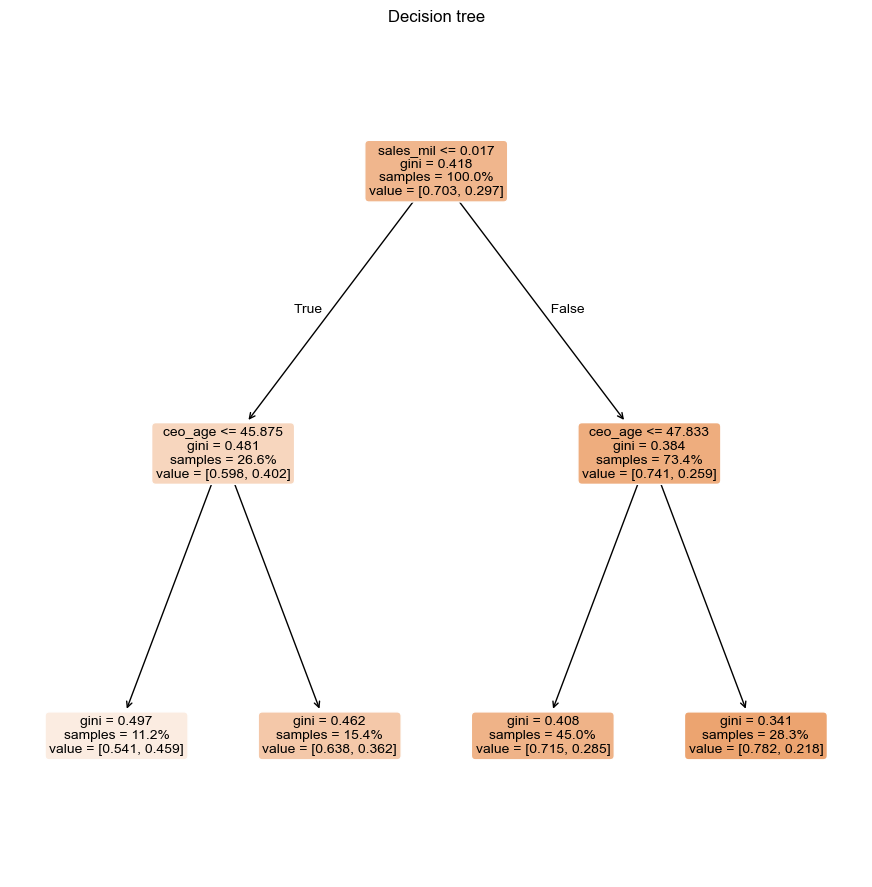

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

data_for_graph = data_train[["sales_mil", "profit_loss_year", "ceo_age"]]
rf_for_graph = DecisionTreeClassifier(
    ccp_alpha=0.001, min_samples_leaf=100, max_depth=3, random_state=41
).fit(data_for_graph, y_train)

plt.figure()
plt.figure(figsize=(11, 11))
plot_tree(
    rf_for_graph,
    feature_names=data_for_graph.columns,
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
)
plt.title("Decision tree")
plt.show()


## Probability forest

Split by gini, ratio of 1's in each tree, average over trees

In [61]:
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

5 fold cross validation

In [62]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

In [63]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

Create CV summary table

In [64]:
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.671993,0.435210
1,5,16,0.672103,0.435108
2,6,11,0.670321,0.435484
3,6,16,0.670663,0.435287
4,7,11,0.670494,0.435475
5,7,16,0.670105,0.435576


Obtain optimal parameter values

In [65]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_


{'criterion': 'gini', 'max_features': 5, 'min_samples_split': 16}

Get average (ie over the folds) RMSE and AUC

In [66]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [67]:
summary.loc["RF", "Number of Coefficients"] = np.nan
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,12.0,0.450373,0.606183
M2,19.0,0.444576,0.640386
M3,36.0,0.439932,0.660361
M4,79.0,0.437121,0.664911
M5,153.0,0.436867,0.667483
LASSO,110.0,0.436442,0.669907
RF,NaN,0.435108,0.672103


Extract fold level RMSE and AUC

In [68]:
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

Take a look at foldwise RMSE and AUC

In [69]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.457071,0.451474,0.446976,0.443774,0.443991,0.443004,0.441892
1,0.444317,0.440299,0.435901,0.432761,0.431186,0.430772,0.431132
2,0.449332,0.441784,0.434388,0.432584,0.432418,0.432573,0.429126
3,0.449140,0.443769,0.442930,0.440497,0.441838,0.441342,0.439103
4,0.452004,0.445551,0.439465,0.435990,0.434904,0.434517,0.434152


In [70]:
pd.DataFrame(CV_AUC_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.606274,0.634755,0.656691,0.661450,0.661761,0.665992,0.668576
1,0.586100,0.620499,0.639485,0.649845,0.659652,0.660837,0.658043
2,0.606938,0.649268,0.677397,0.680086,0.681654,0.682523,0.693921
3,0.626043,0.653496,0.659148,0.662428,0.659111,0.663768,0.661150
4,0.605562,0.643910,0.669086,0.670744,0.675239,0.676415,0.678827


Now use loss function and search for best thresholds and expected loss over folds 

In [71]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["fast_growth"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["fast_growth"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)


In [72]:
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)


In [73]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.435,0.672,0.166,0.176,1.341,1.343


Create plots based on Fold5 in CV 

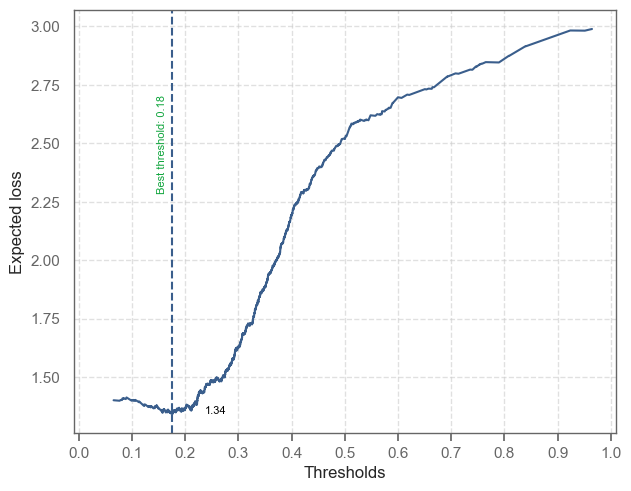

In [74]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

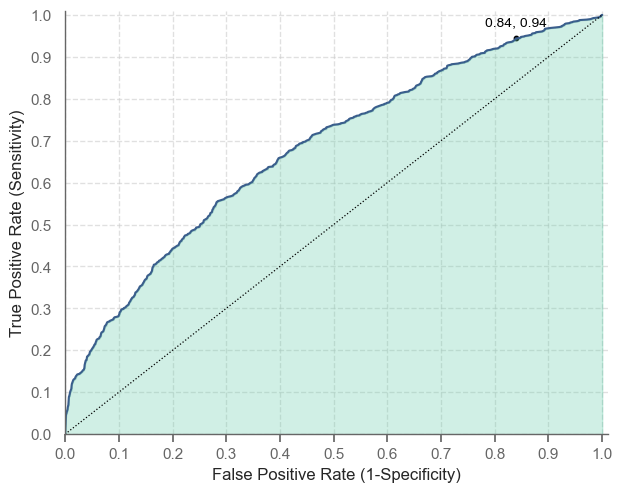

In [75]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

Take model to holdout and estimate RMSE, AUC and expected loss 

In [76]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)


np.float64(0.433)

ROC AUC  on holdout

In [77]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)


0.656

 Get expected loss on holdout

In [78]:
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)


np.float64(1.37)

## Final results

In [79]:
summary["CV treshold"] = best_thresholds_cv
summary["CV expected Loss"] = expected_loss_cv

---
# TASK 2: Industry-Specific Analysis

In this section, we analyze fast growth prediction separately for two industry groups:
- **Manufacturing:** Industry codes [26.0, 27.0, 28.0, 29.0, 30.0, 32.0, 33.0]
- **Services:** Industry codes [55.0, 56.0]

We compare:
1. Model performance (RMSE, AUC) between industries
2. Optimal thresholds and expected loss
3. Key predictors and their importance
4. Differences in fast growth patterns

In [80]:
summary

,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
M1,12.0,0.450373,0.606183,0.186479,1.383428
M2,19.0,0.444576,0.640386,0.151181,1.383853
M3,36.0,0.439932,0.660361,0.160749,1.364023
M4,79.0,0.437121,0.664911,0.154932,1.367280
M5,153.0,0.436867,0.667483,0.141282,1.354958
LASSO,110.0,0.436442,0.669907,0.155241,1.351983
RF,NaN,0.435108,0.672103,0.165901,1.341360


In [81]:
# ==========================================================================
# TASK 2: INDUSTRY COMPARISON (Manufacturing vs Services)
# ==========================================================================


# 1. Define industry codes (using floats to match data format)
# Manufacturing: 26.0, 27.0, ... 
mfg_codes = [26.0, 27.0, 28.0, 29.0, 30.0, 32.0, 33.0]

# Services: 55.0, 56.0
service_codes = [55.0, 56.0]

# 2. Create subsets (ensure ind2_cat column exists)
data_mfg = data.loc[data['ind2_cat'].isin(mfg_codes)].copy()
data_serv = data.loc[data['ind2_cat'].isin(service_codes)].copy()

print(f"Manufacturing Data Shape: {data_mfg.shape}")
print(f"Services Data Shape: {data_serv.shape}")


# 3. Define a function to train and evaluate the "best model" (using Random Forest)
def train_and_evaluate(subset_data, subset_name):
    print(f"\n--- Running model for: {subset_name} ---")
    
    
    predictors = rfvars
    
    # 2. Construct formula string
    # Format: "fast_growth ~ sales_mil + C(ind2_cat) + ..."
    model_formula = "fast_growth ~ " + "+".join(predictors)
    
    # 3. Use patsy to generate design matrix (automatically handles C() categorical variables)
    # This generates y (N x 1) and X (N x k) DataFrames
    y, X = patsy.dmatrices(model_formula, subset_data, return_type='dataframe')
    
    # y is a DataFrame by default, convert to 1D Series to avoid sklearn warnings
    y = y.iloc[:, 0]


    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Initialize model (using the best parameters from Task 1)
    rf_model = RandomForestClassifier(
        n_estimators=500, 
        max_features=5,
        min_samples_split=15, 
        random_state=42,
        n_jobs=-1
    )
    
    # Train
    rf_model.fit(X_train, y_train)
    
    # Predict probabilities
    y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc_score = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC ({subset_name}): {auc_score:.3f}")
    
    # Find optimal threshold (using previously defined loss function parameters)
    # cost = FN/FP (ensure cost variable is defined earlier)
    # For simplicity, we use ROC curve to find the optimal point, or reuse your previous logic
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    # Simple loss minimization logic: loss = fpr*FP + (1-tpr)*FN
    ix = np.argmin(fpr * FP + (1 - tpr) * FN) 
    best_thresh = thresholds[ix]

    y_pred_class = (y_pred_prob >= best_thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()

    min_loss = (fp * FP + fn * FN) / len(y_test) # Expected loss per case
    
    print(f"Best Threshold: {best_thresh:.3f}")
    print(f"Expected Loss: {min_loss:.3f}")
    
    return auc_score, min_loss

# 4. If data has sufficient samples (>0), run training function
if len(data_mfg) > 0:
    auc_mfg, loss_mfg = train_and_evaluate(data_mfg, "Manufacturing")
else:
    print("Error: Manufacturing dataset is empty! Check mfg_codes.")

if len(data_serv) > 0:
    auc_serv, loss_serv = train_and_evaluate(data_serv, "Services")
else:
    print("Error: Services dataset is empty! Check service_codes.")

# 5. Simple comparison summary
print("\n--- Comparison Summary ---")
print(f"Manufacturing: AUC={auc_mfg:.3f}, Loss={loss_mfg:.3f}")
print(f"Services:      AUC={auc_serv:.3f}, Loss={loss_serv:.3f}")


Manufacturing Data Shape: (5354, 118)
Services Data Shape: (12296, 118)

--- Running model for: Manufacturing ---
AUC (Manufacturing): 0.623
Best Threshold: 0.151
Expected Loss: 1.326

--- Running model for: Services ---
AUC (Services): 0.684
Best Threshold: 0.084
Expected Loss: 1.391

--- Comparison Summary ---
Manufacturing: AUC=0.623, Loss=1.326
Services:      AUC=0.684, Loss=1.391
